In [69]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


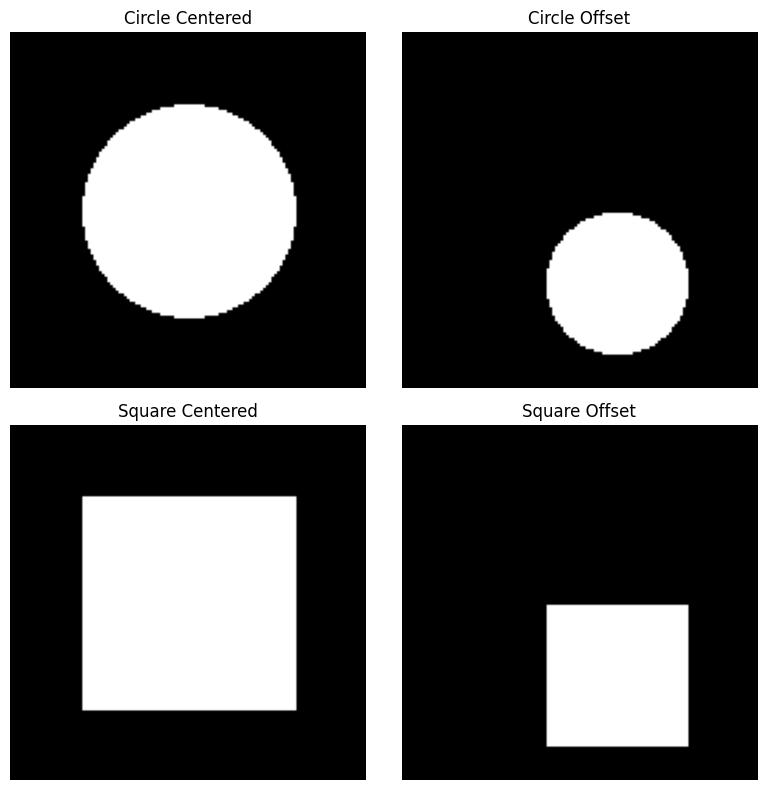

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from core.linalg_utils import circular_aperture, square_aperture

# テスト用画像サイズ
shape = (128, 128)

# 半径の正規化スケールでの指定
r = 0.3

# 原点中心（デフォルト）
circle_mask = circular_aperture(shape, radius=r)
square_mask = square_aperture(shape, radius=r)

# 原点からずらした中心 (0.1, -0.2)
offset_center = (0.1, -0.2)
circle_offset = circular_aperture(shape, radius=0.2, center=offset_center)
square_offset = square_aperture(shape, radius=0.2, center=offset_center)

# 可視化
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(circle_mask, cmap="gray")
axs[0, 0].set_title("Circle Centered")

axs[0, 1].imshow(circle_offset, cmap="gray")
axs[0, 1].set_title("Circle Offset")

axs[1, 0].imshow(square_mask, cmap="gray")
axs[1, 0].set_title("Square Centered")

axs[1, 1].imshow(square_offset, cmap="gray")
axs[1, 1].set_title("Square Offset")

for ax in axs.ravel():
    ax.axis("off")

plt.tight_layout()
plt.show()


In [71]:
import numpy as np
from core.metrics import mse
from graph.prior.support_prior import SupportPrior
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from graph.measurement.masked_gaussian_measurement import MaskedGaussianMeasurement
from graph.structure.graph import Graph
from core.linalg_utils import circular_aperture, random_binary_mask

# ==== 1. パラメータ設定 ====
H, W = 64, 64
shape = (H, W)
support_radius = 0.35  
mask_ratio = 0.6    # 観測率
var = 1e-4
rng = np.random.default_rng(seed=42)

# ==== 2. グラフ定義 ====
class CSGraph(Graph):
    def __init__(self):
        super().__init__()

        support = circular_aperture(shape, radius=support_radius)
        self.X = SupportPrior(support=support, dtype=np.complex128, damping = 0.01)
        self.Y =  FFT2DPropagator(shape=(H, W)) @ self.X 
        mask = random_binary_mask((H, W), subsampling_rate=mask_ratio, rng=rng)
        self.Z = MaskedGaussianMeasurement(input_wave=self.Y, var=var, mask=mask)
        self.compile()

# ==== 3. グラフ生成・初期化 ====
g = CSGraph()
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=10))

true_x = g.X.get_sample()
observed = g.Z.get_sample()

In [72]:
def monitor(graph, t):
    est = graph.X.compute_belief().data
    err = mse(est, true_x)
    if t % 5 == 0:
        print(f"[t={t}] MSE = {err:.5e}")

g.run(n_iter=100, callback=monitor)


[t=0] MSE = 1.13481e+00
[t=5] MSE = 1.38207e-02
[t=10] MSE = 3.33697e-03
[t=15] MSE = 1.59509e-03
[t=20] MSE = 9.54322e-04
[t=25] MSE = 6.60184e-04
[t=30] MSE = 5.07011e-04
[t=35] MSE = 4.20379e-04
[t=40] MSE = 3.68604e-04
[t=45] MSE = 3.36513e-04
[t=50] MSE = 3.16168e-04
[t=55] MSE = 3.03124e-04
[t=60] MSE = 2.94756e-04
[t=65] MSE = 2.89450e-04
[t=70] MSE = 2.86181e-04
[t=75] MSE = 2.84279e-04
[t=80] MSE = 2.83302e-04
[t=85] MSE = 2.82947e-04
[t=90] MSE = 2.83011e-04
[t=95] MSE = 2.83350e-04


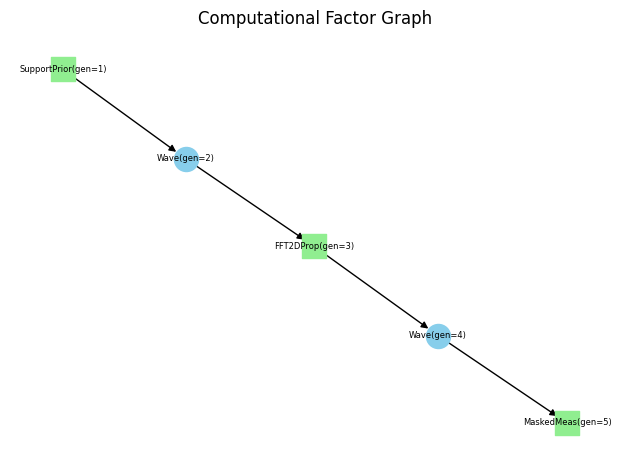

In [73]:
g.visualize(layout="kamada_kawai", font_size=6, scale=2.0)

In [74]:
0.35**2 * np.pi

0.3848451000647496